In [1]:
import os
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from zipfile import ZipFile
import seaborn as sns 


In [2]:
DATA_PATH = "./00_source_data"
arrests_data = os.path.join(DATA_PATH, 'ucr_arrests_monthly_all'
                                       '_crimes_race_sex_1974_2020_dta.zip')

zip_file = ZipFile(arrests_data)
dfs = {text_file.filename: pd.read_stata(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.dta')}
zip_file.close()


print(dfs.keys())
arrests_2019 = dfs['ucr_arrests_monthly_all_crimes_race_sex_2019.dta'].copy()
arrests_2020 = dfs['ucr_arrests_monthly_all_crimes_race_sex_2020.dta'].copy()
print(arrests_2019.shape)
print(arrests_2020.shape)
zip_file = ZipFile(os.path.join(DATA_PATH, 'crime.zip'))
dfs = {text_file.filename: pd.read_csv(zip_file.open(text_file.filename))
       for text_file in zip_file.infolist()
       if text_file.filename.endswith('.csv')}
zip_file.close()
print(dfs.keys())
crime_data = dfs['crime.csv'].copy()
offense_codes = dfs['offense_codes.csv'].copy()
print(crime_data.shape)
print(offense_codes.shape)

dict_keys(['ucr_arrests_monthly_all_crimes_race_sex_2019.dta', 'ucr_arrests_monthly_all_crimes_race_sex_2020.dta'])
(233476, 1227)
(236468, 1233)
dict_keys(['crime.csv', 'offense_codes.csv'])
(473344, 19)
(299, 9)


### Preprocessing 

In [3]:
arrests_2019_cols = set(arrests_2019.columns)
arrests_2020_cols = set(arrests_2020.columns)
print(arrests_2019_cols.difference(arrests_2020_cols))
print("*" * 50)
print(arrests_2020_cols.difference(arrests_2019_cols))
print("*" * 50)
print(len(arrests_2020_cols.intersection(arrests_2019_cols)))

set()
**************************************************
{'address_zip_code', 'address_name', 'address_city', 'address_street_line_2', 'address_street_line_1', 'address_state'}
**************************************************
1227


In [4]:
columns_to_remove = list(arrests_2020_cols.difference(arrests_2019_cols))
arrests_2020.drop(columns_to_remove, axis=1, inplace=True)
assert arrests_2019.shape[1] == arrests_2020.shape[1]

In [46]:
# 08041
arrests_2020_filtered = arrests_2020.query("state_abb == 'CO'").copy()
arrests_2019_filtered = arrests_2019.query("state_abb == 'CO'").copy()
arrests_2020.loc[(arrests_2020['fips_state_county_code'] == '') &
                 (arrests_2020['agency_name'] == 'us secret service, denve'), 'fips_state_county_code'] = '08031'
arrests_2019.loc[(arrests_2019['fips_state_county_code'] == '') &
                 (arrests_2019['agency_name'] == 'us secret service, denve'), 'fips_state_county_code'] = '08031'
arrests_2020_filtered = arrests_2020_filtered.query("fips_state_county_code in ['08031', '08013', '08014','08001','08041']").copy()
arrests_2019_filtered = arrests_2019_filtered.query("fips_state_county_code in ['08031', '08013', '08014','08001','08041']").copy()
print(arrests_2020_filtered.shape)
print(arrests_2019_filtered.shape)

general_cols = arrests_2020_filtered.columns.to_list()[:14]
arrest_cols = [col for col in arrests_2020_filtered.columns if 'tot_arrest' in col]
arrests_2020_filtered = arrests_2020_filtered[general_cols + arrest_cols]
arrests_2019_filtered = arrests_2019_filtered[general_cols + arrest_cols]
arrests_df = pd.concat([arrests_2019_filtered, arrests_2020_filtered], axis=0)
print(arrests_df.shape)

(360, 1227)
(372, 1227)
(732, 57)


In [47]:
arrests_agg = (arrests_df
               .groupby(['month', 'year', 'fips_state_county_code'], as_index=False)[arrest_cols].sum())
population_norm = (arrests_df
                   .groupby(['month', 'year', 'fips_state_county_code', 'fips_place_code'], as_index=False)[
                       'population']
                   .max()
                   .groupby(['month', 'year', 'fips_state_county_code'], as_index=False)[['population']]
                   .sum())
merged = pd.merge(arrests_agg, population_norm, on=['month', 'year', 'fips_state_county_code'])
print(merged.shape)
merged.head()

(120, 47)


,month,year,fips_state_county_code,agg_assault_tot_arrests,all_other_tot_arrests,arson_tot_arrests,burglary_tot_arrests,curfew_loiter_tot_arrests,disorder_cond_tot_arrests,drunkenness_tot_arrests,...,sale_other_drug_tot_arrests,sale_synth_narc_tot_arrests,stolen_prop_tot_arrests,suspicion_tot_arrests,theft_tot_arrests,total_drug_tot_arrests,vagrancy_tot_arrests,vandalism_tot_arrests,weapons_tot_arrests,population
0,april,2019,08001,40,1567,0,8,3,102,0,...,2,0,9,0,211,148,1,52,22,466854
1,april,2019,08013,18,532,1,12,0,24,0,...,0,0,3,0,105,57,0,22,5,317073
2,april,2019,08014,1,31,0,2,0,1,0,...,4,0,0,0,43,26,0,5,0,70798
3,april,2019,08031,143,848,1,38,26,62,0,...,5,1,12,0,196,350,2,98,73,728941
4,april,2019,08041,120,801,1,61,0,35,0,...,4,0,4,0,253,135,0,49,35,722447


In [48]:
violent_crime = ['agg_assault_tot_arrests', 'arson_tot_arrests', 'burglary_tot_arrests',
                 'manslaught_neg_tot_arrests', 'murder_tot_arrests', 'oth_assault_tot_arrests',
                 'oth_sex_off_tot_arrests', 'rape_tot_arrests', 'robbery_tot_arrests']
non_violent = list(set(arrest_cols).difference(set(violent_crime)))


In [49]:
non_violent_df = merged[['month', 'year', 'fips_state_county_code', 'population'] + non_violent].copy()
print(non_violent_df.shape)
non_violent_df['grand_total'] = np.sum(merged[non_violent], axis=1)
non_violent_df['arrest_rate_gt'] = non_violent_df['grand_total'] / non_violent_df['population'] * 100_000
non_violent_df[0:10]

(120, 38)


,month,year,fips_state_county_code,population,total_drug_tot_arrests,gamble_bookmake_tot_arrests,prostitution_tot_arrests,poss_other_drug_tot_arrests,sale_other_drug_tot_arrests,theft_tot_arrests,...,sale_synth_narc_tot_arrests,poss_synth_narc_tot_arrests,forgery_tot_arrests,sale_drug_total_tot_arrests,curfew_loiter_tot_arrests,fraud_tot_arrests,poss_cannabis_tot_arrests,suspicion_tot_arrests,grand_total,arrest_rate_gt
0,april,2019,08001,466854,148,0,0,58,2,211,...,0,2,9,13,3,21,49,0,2691,576.411469
1,april,2019,08013,317073,57,0,1,22,0,105,...,0,2,6,8,0,11,23,0,1038,327.369407
2,april,2019,08014,70798,26,0,0,8,4,43,...,0,0,0,4,0,6,10,0,176,248.594593
3,april,2019,08031,728941,350,0,22,134,5,196,...,1,2,14,43,26,33,24,0,3227,442.697008
4,april,2019,08041,722447,135,0,4,72,4,253,...,0,1,5,14,0,22,20,0,1910,264.379256
5,april,2020,08001,470626,82,0,0,33,8,132,...,1,4,7,13,7,18,5,0,1021,216.945090
6,april,2020,08013,315516,9,0,0,5,1,71,...,0,0,0,1,0,4,0,0,400,126.776455
7,april,2020,08014,71795,3,0,0,2,0,18,...,0,0,0,0,0,2,0,0,52,72.428442
8,april,2020,08031,737709,111,0,0,32,5,166,...,0,0,6,19,7,18,20,0,1580,214.176593
9,april,2020,08041,726916,105,0,1,59,5,223,...,0,0,5,16,0,14,6,0,1558,214.330129


In [50]:
violent_df = merged[['month', 'year', 'fips_state_county_code', 'population'] + violent_crime].copy()
print(violent_df.shape)
violent_df['grand_total'] = np.sum(merged[violent_crime], axis=1)
violent_df['arrest_rate_gt'] = violent_df['grand_total'] / violent_df['population'] * 100_000
violent_df.head()

(120, 13)


,month,year,fips_state_county_code,population,agg_assault_tot_arrests,arson_tot_arrests,burglary_tot_arrests,manslaught_neg_tot_arrests,murder_tot_arrests,oth_assault_tot_arrests,oth_sex_off_tot_arrests,rape_tot_arrests,robbery_tot_arrests,grand_total,arrest_rate_gt
0,april,2019,08001,466854,40,0,8,0,1,132,5,3,6,195,41.768947
1,april,2019,08013,317073,18,1,12,0,4,67,0,2,3,107,33.746172
2,april,2019,08014,70798,1,0,2,0,0,15,0,1,1,20,28.249386
3,april,2019,08031,728941,143,1,38,0,6,264,17,12,35,516,70.787622
4,april,2019,08041,722447,120,1,61,1,4,222,10,13,25,457,63.257235


### EDA

In [51]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=[ 'january', 'february', 'march',
'april', 'may', 'june', 'july','august', 'september', 'october', 'november',
 'december',], ordered=True)

non_violent_df['month'] = non_violent_df['month'].astype(cat_type)
#violent_df['month'] = violent_df['month'].astype(cat_type)


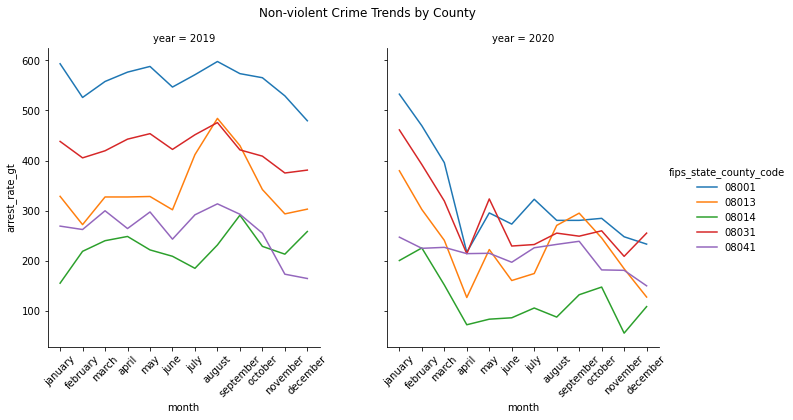

In [52]:
import matplotlib.pyplot as plt

g = sns.FacetGrid(non_violent_df, col="year", hue="fips_state_county_code")
g.map(sns.lineplot, "month", "arrest_rate_gt")
g.set_xticklabels(rotation =45)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
g.fig.suptitle('Non-violent Crime Trends by County ')
g.add_legend()

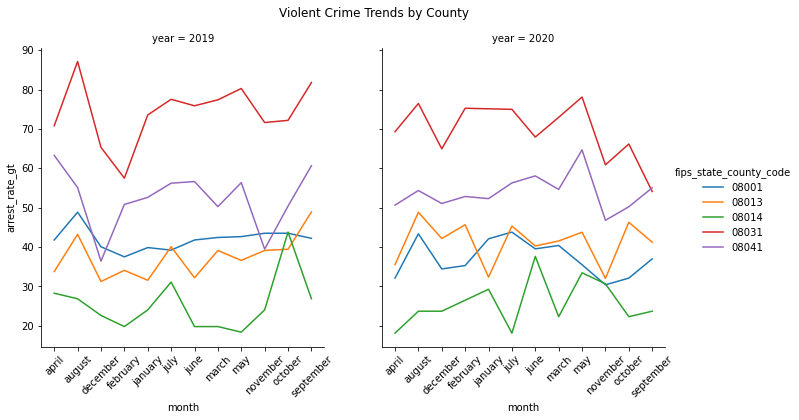

In [53]:
g = sns.FacetGrid(violent_df, col="year", hue="fips_state_county_code")
g.map(sns.lineplot, "month", "arrest_rate_gt")
g.set_xticklabels(rotation =45)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
g.fig.suptitle('Violent Crime Trends by County ')
g.add_legend()

In [54]:
non_violent_df['curfew_loiter_tot_arrests_rate'] = non_violent_df['curfew_loiter_tot_arrests'] / non_violent_df['population'] * 100_000


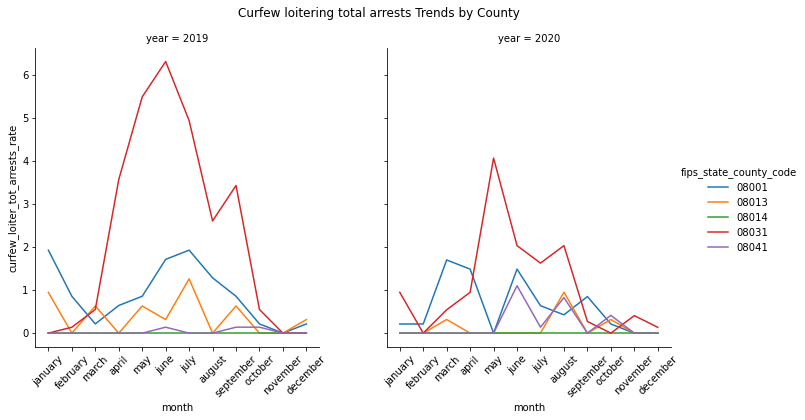

In [55]:

g = sns.FacetGrid(non_violent_df, col="year", hue="fips_state_county_code")
g.map(sns.lineplot, "month", "curfew_loiter_tot_arrests_rate")
g.set_xticklabels(rotation =45)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
g.fig.suptitle('Curfew loitering total arrests Trends by County ')
g.add_legend()

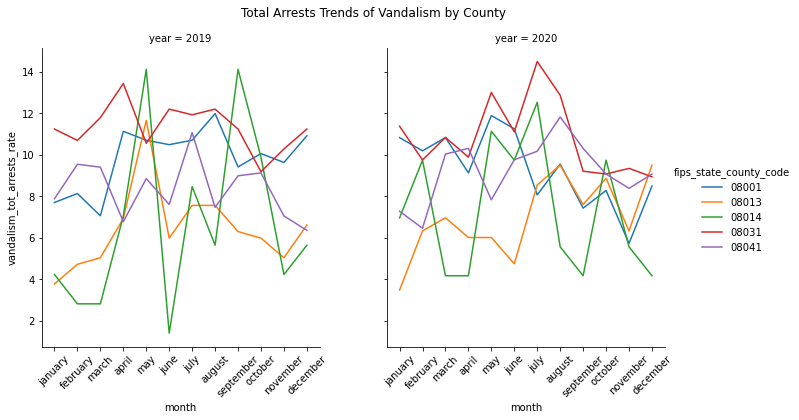

In [56]:
non_violent_df['vandalism_tot_arrests_rate'] = non_violent_df['vandalism_tot_arrests'] / non_violent_df['population'] * 100_000

g = sns.FacetGrid(non_violent_df, col="year", hue="fips_state_county_code")
g.map(sns.lineplot, "month", "vandalism_tot_arrests_rate")
g.set_xticklabels(rotation =45)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
g.fig.suptitle('Total Arrests Trends of Vandalism by County ')
g.add_legend()

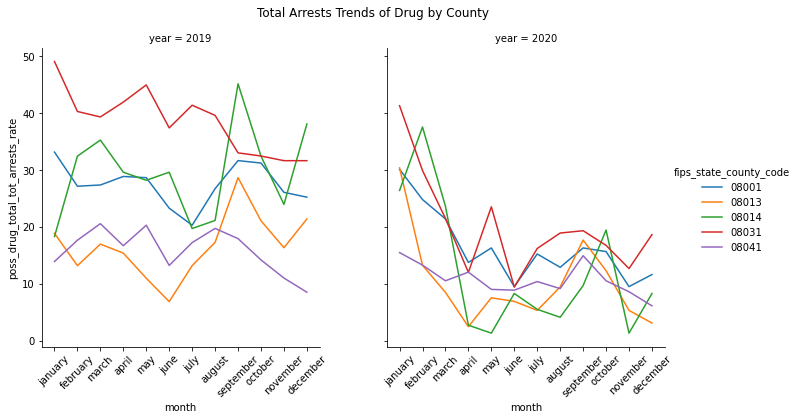

In [57]:
non_violent_df['poss_drug_total_tot_arrests_rate'] = non_violent_df['poss_drug_total_tot_arrests'] / non_violent_df['population'] * 100_000

g = sns.FacetGrid(non_violent_df, col="year", hue="fips_state_county_code")
g.map(sns.lineplot, "month", "poss_drug_total_tot_arrests_rate")
g.set_xticklabels(rotation =45)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
g.fig.suptitle('Total Arrests Trends of Drug by County ')
g.add_legend()

In [88]:

def filter_columns(col_type: str, df): 
    """
    Input column type : male, female, black, asian, amer_ind, white, hispanic, non_hispanic
    Input DF: 2019 dataframe or 2020 dataframe (filtered by Colorado and county code already)
    Return: Data frame with columns we want 
    """
    general_cols = df.columns.to_list()[:14]
    cols = [col for col in df.columns if col.endswith('tot_'+ col_type)]
    filtered = df[general_cols + cols]
    return filtered, cols




def merge_data(df_2019, df_2020, cols):
    # concat two data frame to one 
    arrests_df = pd.concat([df_2019, df_2020], axis=0)
    arrests_agg = (arrests_df
               .groupby(['month', 'year', 'fips_state_county_code'], as_index=False)[cols].sum())
    population_norm = (arrests_df
                   .groupby(['month', 'year', 'fips_state_county_code', 'fips_place_code'], as_index=False)[
                       'population']
                   .max()
                   .groupby(['month', 'year', 'fips_state_county_code'], as_index=False)[['population']]
                   .sum())
    merged = pd.merge(arrests_agg, population_norm, on=['month', 'year', 'fips_state_county_code'])
    return merged


def violent_crime_split(merged_data, col_type: str ):
    """
    Input: merged data that contains dataframe from 2019 and 2020
    Input column type : male, female, black, asian, amer_ind, white, hispanic, non_hispanic
    ouput: dataframe with non violent, and a dataframe with violent
    """
    violent_crime = ['agg_assault_tot', 'arson_tot', 'burglary_tot',
                 'manslaught_neg_tot', 'murder_tot', 'oth_assault_tot',
                 'oth_sex_off_tot', 'rape_tot', 'robbery_tot']
    violent_s = [i+'_'+col_type for i in violent_crime]
    gen_col = ['month', 'year', 'fips_state_county_code', 'population']
    non_violent_s = list(set(merged_data.columns).difference(set(violent_s+gen_col )))
    non_violent_df = merged_data[['month', 'year', 'fips_state_county_code', 'population'] + non_violent_s].copy()
    violent_df = merged_data[['month', 'year', 'fips_state_county_code', 'population'] + violent_s].copy()
    violent_df['grand_total_'+col_type] = np.sum(violent_df[violent_s], axis=1)
    non_violent_df['grand_total_'+col_type] = np.sum(non_violent_df[non_violent_s], axis=1)
    non_violent_df['rate_gt_'+col_type] = non_violent_df['grand_total_'+col_type] / non_violent_df['population'] * 100_000
    violent_df['rate_gt_'+col_type] = violent_df['grand_total_'+col_type] / violent_df['population'] * 100_000
    return non_violent_df, violent_df 

In [63]:
arrests_2020_filtered = arrests_2020.query("state_abb == 'CO'").copy()
arrests_2019_filtered = arrests_2019.query("state_abb == 'CO'").copy()
arrests_2020.loc[(arrests_2020['fips_state_county_code'] == '') &
                 (arrests_2020['agency_name'] == 'us secret service, denve'), 'fips_state_county_code'] = '08031'
arrests_2019.loc[(arrests_2019['fips_state_county_code'] == '') &
                 (arrests_2019['agency_name'] == 'us secret service, denve'), 'fips_state_county_code'] = '08031'
arrests_2020_filtered = arrests_2020_filtered.query("fips_state_county_code in ['08031', '08013', '08014','08001','08041']").copy()
arrests_2019_filtered = arrests_2019_filtered.query("fips_state_county_code in ['08031', '08013', '08014','08001','08041']").copy()
print(arrests_2020_filtered.shape)
print(arrests_2019_filtered.shape)
filtered_2020 = filter_columns('arrests',arrests_2020_filtered)[0]
filtered_2019 = filter_columns('arrests',arrests_2019_filtered)[0]
column_list = filter_columns('arrests',arrests_2019_filtered)[1]


(360, 1227)
(372, 1227)


In [65]:
merged_df = merge_data(filtered_2020, filtered_2019, column_list)


In [89]:
no_vio, vio = violent_crime_split(merged_df, 'arrests')


In [90]:
vio.columns

Index(['month', 'year', 'fips_state_county_code', 'population',
       'agg_assault_tot_arrests', 'arson_tot_arrests', 'burglary_tot_arrests',
       'manslaught_neg_tot_arrests', 'murder_tot_arrests',
       'oth_assault_tot_arrests', 'oth_sex_off_tot_arrests',
       'rape_tot_arrests', 'robbery_tot_arrests', 'grand_total_arrests',
       'rate_gt_arrests'],
      dtype='object')

In [91]:
no_vio.columns

Index(['month', 'year', 'fips_state_county_code', 'population',
       'total_drug_tot_arrests', 'gamble_bookmake_tot_arrests',
       'prostitution_tot_arrests', 'poss_other_drug_tot_arrests',
       'sale_other_drug_tot_arrests', 'theft_tot_arrests',
       'poss_heroin_coke_tot_arrests', 'liquor_tot_arrests',
       'gamble_total_tot_arrests', 'vagrancy_tot_arrests',
       'gamble_other_tot_arrests', 'disorder_cond_tot_arrests',
       'vandalism_tot_arrests', 'poss_drug_total_tot_arrests',
       'runaways_tot_arrests', 'all_other_tot_arrests',
       'stolen_prop_tot_arrests', 'dui_tot_arrests',
       'gamble_lottery_tot_arrests', 'weapons_tot_arrests',
       'family_off_tot_arrests', 'drunkenness_tot_arrests',
       'sale_heroin_coke_tot_arrests', 'mtr_veh_theft_tot_arrests',
       'sale_cannabis_tot_arrests', 'embezzlement_tot_arrests',
       'sale_synth_narc_tot_arrests', 'poss_synth_narc_tot_arrests',
       'forgery_tot_arrests', 'sale_drug_total_tot_arrests',
       'c

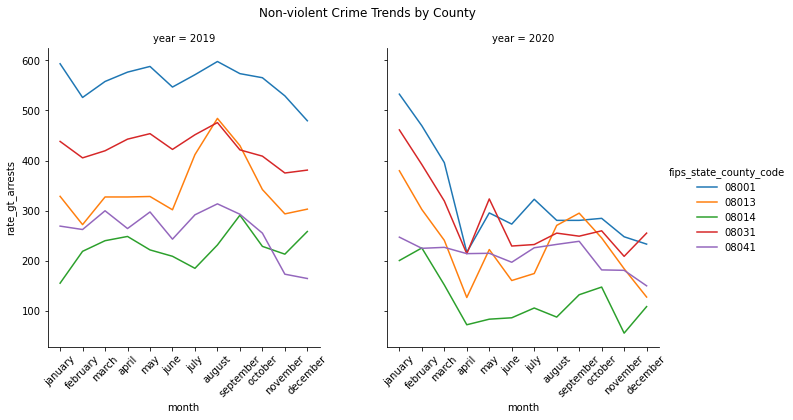

In [94]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=[ 'january', 'february', 'march',
'april', 'may', 'june', 'july','august', 'september', 'october', 'november',
 'december',], ordered=True)

no_vio['month'] = no_vio['month'].astype(cat_type)
#violent_df['month'] = violent_df['month'].astype(cat_type)

g = sns.FacetGrid(no_vio, col="year", hue="fips_state_county_code")
g.map(sns.lineplot, "month", "rate_gt_arrests")
g.set_xticklabels(rotation =45)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)
g.fig.suptitle('Non-violent Crime Trends by County ')
g.add_legend()